In [4]:
import sys
import os
sys.path.append('../')
rootPath = os.path.dirname(sys.path[0])
sys.path.append(rootPath)
import argparse
import os.path as ops
import cv2
import numpy as np
import tensorflow as tf
import json
import time
import argparse
import math
import json
import glog as logger
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
from tensorflow.python.ops import random_ops

from train_model.tools import evaluation_tools
from train_model.crnn_model import crnn_model
from train_model.config import model_config
from train_model.data_provider import read_tfrecord
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
CFG = model_config.cfg
print(tf.__version__)

1.15.2


### 生成训练数据
```
!sh shell/generation_cn_tfrecord.sh  ~/sample_data/test.txt  0.2
```

In [5]:
def get_num_class(char_dict_path):
    """
    get the number of char classes automatically
    :param char_dict_path: path for char_dictionary
    """
    char_map_dict = json.load(open(char_dict_path, 'r',encoding='utf-8'))
    if char_map_dict is None:
        print("error")
    assert (isinstance(char_map_dict, dict) and 'char_map_dict is not a dict')
    num_class = len(char_map_dict.keys())+1
    return num_class

def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
      tower_grads: List of lists of (gradient, variable) tuples. The outer list
        is over individual gradients. The inner list is over the gradient
        calculation for each tower.
    Returns:
       List of pairs of (gradient, variable) where the gradient has been averaged
       across all towers.
    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads, 0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)

    return average_grads


def compute_net_gradients(images, labels, net, optimizer=None, is_net_first_initialized=False):

    _, net_loss = net.compute_loss(
        inputdata=images,
        labels=labels,
        name='shadow_net',
        reuse=is_net_first_initialized
    )

    if optimizer is not None:
        grads = optimizer.compute_gradients(net_loss)
    else:
        grads = None

    return net_loss, grads



In [8]:
def train_shadownet_multi_gpu(dataset_dir_train, dataset_dir_val, weights_path, char_dict_path, save_path):
    """

    :param dataset_dir:
    :param weights_path:
    :param char_dict_path:
    :param ord_map_dict_path:
    :return:
    """
    #caculdate num_class

    NUM_CLASSES = get_num_class(char_dict_path)
    print('---NUM_CLASSES------- ', NUM_CLASSES)

    # prepare dataset
    train_dataset = read_tfrecord.CrnnDataFeeder(
        dataset_dir=dataset_dir_train, char_dict_path=char_dict_path, flags='train')

    train_images, train_labels, train_images_paths = train_dataset.inputs(
        batch_size=CFG.TRAIN.BATCH_SIZE)

    val_dataset = read_tfrecord.CrnnDataFeeder(
        dataset_dir=dataset_dir_val, char_dict_path=char_dict_path, flags='val')

    val_images, val_labels, val_images_paths = val_dataset.inputs(
        batch_size=CFG.TRAIN.BATCH_SIZE)


    # set crnn net
    shadownet = crnn_model.ShadowNet(
        phase='train',
        hidden_nums=CFG.ARCH.HIDDEN_UNITS,
        layers_nums=CFG.ARCH.HIDDEN_LAYERS,
        num_classes=NUM_CLASSES
    )
    shadownet_val = crnn_model.ShadowNet(
        phase='test',
        hidden_nums=CFG.ARCH.HIDDEN_UNITS,
        layers_nums=CFG.ARCH.HIDDEN_LAYERS,
        num_classes=NUM_CLASSES
    )


    # set average container
    tower_grads = []
    train_tower_loss = []
    val_tower_loss = []
    batchnorm_updates = None
    train_summary_op_updates = None

    # set lr
    global_step = tf.Variable(0, name='global_step', trainable=False)
    learning_rate = tf.train.exponential_decay(
        learning_rate=CFG.TRAIN.LEARNING_RATE,
        global_step=global_step,
        decay_steps=CFG.TRAIN.LR_DECAY_STEPS,
        decay_rate=CFG.TRAIN.LR_DECAY_RATE,
        staircase=True)

    # set up optimizer
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

    # set distributed train op
    with tf.variable_scope(tf.get_variable_scope()):
        is_network_initialized = False
        for i in range(CFG.TRAIN.GPU_NUM):
            with tf.device('/gpu:{:d}'.format(i)):
                with tf.name_scope('tower_{:d}'.format(i)) as _:
                    train_loss, grads = compute_net_gradients(
                        train_images, train_labels, shadownet, optimizer,
                        is_net_first_initialized=is_network_initialized)

                    is_network_initialized = True

                    # Only use the mean and var in the first gpu tower to update the parameter
                    if i == 0:
                        batchnorm_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
                        train_summary_op_updates = tf.get_collection(tf.GraphKeys.SUMMARIES)

                    tower_grads.append(grads)
                    train_tower_loss.append(train_loss)
                with tf.name_scope('validation_{:d}'.format(i)) as _:
                    val_loss, _ = compute_net_gradients(
                        val_images, val_labels, shadownet_val, optimizer,
                        is_net_first_initialized=is_network_initialized)
                    val_tower_loss.append(val_loss)

    grads = average_gradients(tower_grads)
    avg_train_loss = tf.reduce_mean(train_tower_loss)
    avg_val_loss = tf.reduce_mean(val_tower_loss)

    # Track the moving averages of all trainable variables
    variable_averages = tf.train.ExponentialMovingAverage(
        CFG.TRAIN.MOVING_AVERAGE_DECAY, num_updates=global_step)
    variables_to_average = tf.trainable_variables() + tf.moving_average_variables()
    variables_averages_op = variable_averages.apply(variables_to_average)

    # Group all the op needed for training
    batchnorm_updates_op = tf.group(*batchnorm_updates)
    apply_gradient_op = optimizer.apply_gradients(grads, global_step=global_step)
    train_op = tf.group(apply_gradient_op, variables_averages_op,
                        batchnorm_updates_op)

    # set tensorflow summary
    
    os.makedirs(save_path, exist_ok=True)
    avg_train_loss_scalar = tf.summary.scalar(name='train_ctc_loss', tensor=avg_train_loss)
    learning_rate_scalar = tf.summary.scalar(name='learning_rate', tensor=learning_rate)
    avg_val_loss_scalar = tf.summary.scalar(name='val_ctc_loss', tensor=avg_val_loss)
    train_merge_summary_op = tf.summary.merge([avg_train_loss_scalar, learning_rate_scalar])
    val_merge_summary_op = tf.summary.merge([avg_val_loss_scalar])


    # set tensorflow saver
    saver = tf.train.Saver()
    train_start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
    model_name = 'shadownet_{:s}.ckpt'.format(str(train_start_time))
    model_save_path = ops.join(save_path, model_name)

    # set sess config
    sess_config = tf.ConfigProto(device_count={'GPU': CFG.TRAIN.GPU_NUM}, allow_soft_placement=True)
    sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.TRAIN.GPU_MEMORY_FRACTION
    sess_config.gpu_options.allow_growth = CFG.TRAIN.TF_ALLOW_GROWTH
    sess_config.gpu_options.allocator_type = 'BFC'

    summary_writer = tf.summary.FileWriter(save_path)

    # Set the training parameters
    #train_epochs = CFG.TRAIN.EPOCHS
    train_epochs = 10

    sess = tf.Session(config=sess_config)

    summary_writer.add_graph(sess.graph)

    with sess.as_default():
        epoch = 0
        tf.train.write_graph(graph_or_graph_def=sess.graph, logdir='',
                             name='{:s}/shadownet_model.pb'.format(save_path))

        if weights_path is None or not os.path.exists(weights_path):
            logger.info('Training from scratch')
            init = tf.global_variables_initializer()
            sess.run(init)
        else:
            weights_path = tf.train.latest_checkpoint(weights_path)
            logger.info('Restore model from last model checkpoint {:s}'.format(weights_path))
            saver.restore(sess=sess, save_path=weights_path)
            epoch = sess.run(tf.train.get_global_step())

        train_cost_time_mean = []
        val_cost_time_mean = []

        while epoch < train_epochs:
            epoch += 1
            # training part
            t_start = time.time()

            _, train_loss_value, train_summary, lr = \
                sess.run(fetches=[train_op,
                                  avg_train_loss,
                                  train_merge_summary_op,
                                  learning_rate])

            if math.isnan(train_loss_value):
                raise ValueError('Train loss is nan')

            cost_time = time.time() - t_start
            train_cost_time_mean.append(cost_time)

            summary_writer.add_summary(summary=train_summary,
                                       global_step=epoch)

            # validation part
            t_start_val = time.time()

            val_loss_value, val_summary = \
                sess.run(fetches=[avg_val_loss,
                                  val_merge_summary_op])

            summary_writer.add_summary(val_summary, global_step=epoch)

            cost_time_val = time.time() - t_start_val
            val_cost_time_mean.append(cost_time_val)

                
            

            if epoch % 2 ==0:
                logger.info('lr={:4f} step:{:4d} train_loss={:9f}  val_loss= {:9f}' .format( \
                lr, epoch+1, train_loss_value, val_loss_value ))
    saver.save(sess=sess, save_path=model_save_path, global_step=epoch)
    print("step: {}  save path {}".format(epoch, model_save_path))
    sess.close()

In [9]:
%%time
base_dir = '../output/'
train_dataset_dir=base_dir + 'tfrecords/train'
val_dataset_dir=base_dir + 'tfrecords/valid'
char_dict_path=base_dir + 'text_data/char_map.json'
weights_path=base_dir +'model_save/'
tf.reset_default_graph()
sess = train_shadownet_multi_gpu(
            dataset_dir_train=train_dataset_dir,
            dataset_dir_val=val_dataset_dir,
            char_dict_path=char_dict_path,
            weights_path=weights_path,
            save_path=base_dir+'model_save'
        )

---NUM_CLASSES-------  1315
../output/tfrecords/train/train*.tfrecords
../output/tfrecords/valid/val*.tfrecords


I0427 13:23:46.090065 30113 <ipython-input-8-02779ea1626e>:147] **************Restore model from last model checkpoint ../output/model_save/shadownet_2020-04-27-13-22-58.ckpt-10


INFO:tensorflow:Restoring parameters from ../output/model_save/shadownet_2020-04-27-13-22-58.ckpt-10


I0427 13:23:46.093223 30113 saver.py:1284] Restoring parameters from ../output/model_save/shadownet_2020-04-27-13-22-58.ckpt-10


step: 10  save path ../output/model_save/shadownet_2020-04-27-13-23-44.ckpt
CPU times: user 6.26 s, sys: 71.5 ms, total: 6.34 s
Wall time: 6.32 s


#  进行测试 ocr-crnn-tensorflow

In [4]:
def _sparse_matrix_to_list(sparse_matrix, char_map_dict_path=None):
    """
    将矩阵拆分为list，参考：https://github.com/bai-shang/crnn_ctc_ocr.Tensorflow
    :param sparse_matrix:
    :param char_map_dict_path:
    :return:
    """
    
    indices = sparse_matrix.indices
    values = sparse_matrix.values
    dense_shape = sparse_matrix.dense_shape

    # the last index in sparse_matrix is ctc blanck note
    char_map_dict = json.load(open(char_map_dict_path, 'r',encoding='utf-8'))
    if char_map_dict is None:
        print("error")
    assert (isinstance(char_map_dict, dict) and 'char_map_dict is not a dict')

    dense_matrix = len(char_map_dict.keys()) * np.ones(dense_shape, dtype=np.int32)
    for i, indice in enumerate(indices):
        dense_matrix[indice[0], indice[1]] = values[i]
    string_list = []
    for row in dense_matrix:
        string = []
        for val in row:
            string.append(_int_to_string(val, char_map_dict))
        string_list.append(''.join(s for s in string if s != '*'))
    return string_list


def _int_to_string(value, char_map_dict=None):

    if char_map_dict is None:
        print("error")
        #char_map_dict = json.load(open(FLAGS.char_map_json_file, 'r'))
    assert (isinstance(char_map_dict, dict) and 'char_map_dict is not a dict')

    for key in char_map_dict.keys():
        if char_map_dict[key] == int(value):
            return str(key)
        elif len(char_map_dict.keys()) == int(value):
            return ""
    raise ValueError('char map dict not has {:d} value. convert index to char failed.'.format(value))


def recognize_single_image(image_list, weights_path, char_dict_path):

    tf.reset_default_graph()
    char_map_dict = json.load(open(char_dict_path, 'r',encoding='utf-8'))
    num_classes = len(char_map_dict) + 1
    print('num_classes: ',  num_classes)
    
    
    
    inputdata = tf.placeholder(dtype=tf.float32,
                               shape=[1, CFG.ARCH.INPUT_SIZE[1],
                                      CFG.ARCH.INPUT_SIZE[0], CFG.ARCH.INPUT_CHANNELS],  # 宽度可变
                               name='input')
    
    
    net = crnn_model.ShadowNet(phase='test', 
                               hidden_nums=CFG.ARCH.HIDDEN_UNITS,
                               layers_nums=CFG.ARCH.HIDDEN_LAYERS, 
                               num_classes=num_classes)
    
    inference_ret = net.inference(
        inputdata=inputdata,
        name='shadow_net',
        reuse=False
    )
    
    decodes, _ = tf.nn.ctc_beam_search_decoder(inputs=inference_ret, 
                                               sequence_length=int(CFG.ARCH.INPUT_SIZE[0] / 4) * np.ones(1),
                                               merge_repeated=False, beam_width=10)
     
    # config tf saver
    saver = tf.train.Saver()

    # config tf session
    sess_config = tf.ConfigProto(allow_soft_placement=True)
    # sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.TRAIN.GPU_MEMORY_FRACTION
    # sess_config.gpu_options.allow_growth = CFG.TRAIN.TF_ALLOW_GROWTH

    sess_config.gpu_options.allow_growth = True
    sess = tf.Session(config=sess_config)
    weights_path = tf.train.latest_checkpoint(weights_path)
    print('weights_path: ', weights_path)
    with sess.as_default():
        saver.restore(sess=sess, save_path=weights_path)
        
        for image_path, label in image_list:
            print(image_path)
            image_name=image_path.split('/')[-1]
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, dsize=tuple(CFG.ARCH.INPUT_SIZE), interpolation=cv2.INTER_LINEAR)
            image_vis = image
            image = np.array(image, np.float32) / 127.5 - 1.0
            
            
            
            seq_len = np.array([image.shape[1] / 4], dtype=np.int32)
#             print('seq_len ', seq_len)
            preds = sess.run(decodes, feed_dict={inputdata: [image]})
            preds = _sparse_matrix_to_list(preds[0], char_dict_path)
            print('Label: {:25s} Predict: [{:s}]'.format(label, preds[0]))
            
            plt.figure('CRNN Model Demo')
            plt.imshow(image_vis[:, :, (2, 1, 0)])
            plt.show()

    sess.close()

../output/images/train/0.jpg 体育马晓旭意外受伤让国奥警惕
../output/images/train/1.jpg 无奈大雨格外青睐殷家军记者傅
../output/images/train/2.jpg 亚雨沈阳报道来到沈阳，国奥队
../output/images/train/3.jpg 依然没有摆脱雨水的困扰。7月
../output/images/train/4.jpg 31日下午6点，国奥队的日常
num_classes:  1315



W0427 12:59:09.974651 28680 module_wrapper.py:139] From ../train_model/crnn_model/crnn_model.py:119: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0427 12:59:09.976811 28680 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0427 12:59:09.978557 28680 module_wrapper.py:139] From ../train_model/crnn_model/cnn_basenet.py:73: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


W0427 12:59:09.998530 28680 deprecation.py:323] From ../train_model/crnn_model/cnn_basenet.py:332: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Instructions for updating:
Please use `layer.__call__` method instead.


W0427 12:59:10.000576 28680 deprecation.py:323] From /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/layers/normalization.py:327: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


W0427 12:59:10.025984 28680 module_wrapper.py:139] From ../train_model/crnn_model/cnn_basenet.py:145: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


W0427 12:59:10.189112 28680 deprecation.py:323] From ../train_model/crnn_model/crnn_model.py:91: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


W0427 12:59:10.192711 28680 deprecation.py:323] From /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/contrib/rnn/python/ops/rnn.py:239: bidirectional_dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


W0427 12:59:10.194369 28680 deprecation.py:323] From /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/rnn.py:464: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


Instructions for updating:
Please use `layer.add_weight` method instead.


W0427 12:59:10.254167 28680 deprecation.py:323] From /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/rnn_cell_impl.py:958: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0427 12:59:10.263994 28680 deprecation.py:506] From /home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow_core/python/ops/rnn_cell_impl.py:962: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


weights_path:  ../output/model_save/shadownet_2020-04-27-12-32-27.ckpt-4999
INFO:tensorflow:Restoring parameters from ../output/model_save/shadownet_2020-04-27-12-32-27.ckpt-4999


I0427 12:59:10.943500 28680 saver.py:1284] Restoring parameters from ../output/model_save/shadownet_2020-04-27-12-32-27.ckpt-4999


../output/images/train/0.jpg
Label: 体育马晓旭意外受伤让国奥警惕            Predict: [密程密程育程育程育程育程育程育程育程育程育程育程密程]


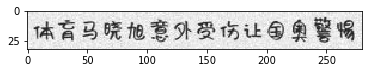

../output/images/train/1.jpg
Label: 无奈大雨格外青睐殷家军记者傅            Predict: [密程密程育程育程育程育程育程育程育程育程育程育程密程]


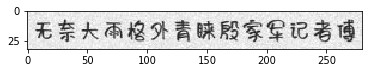

../output/images/train/2.jpg
Label: 亚雨沈阳报道来到沈阳，国奥队            Predict: [密程密程育程育程育程育程育程育程育程育程育程育程密程]


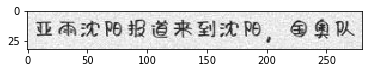

../output/images/train/3.jpg
Label: 依然没有摆脱雨水的困扰。7月            Predict: [密程密程育程育程育程育程育程育程育程育程育程育程密程]


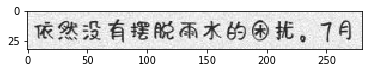

../output/images/train/4.jpg
Label: 31日下午6点，国奥队的日常            Predict: [密程密程育程育程育程育程育程育程育程育程育程育程密程]


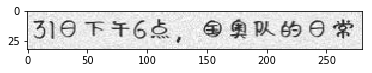

In [8]:
base_dir = '../output/'
train_file = base_dir +  'text_data/train_labels.txt'
images_base_dir = base_dir + 'images/train/'
weights_path= base_dir + 'model_save/'
char_dict_path=base_dir + 'text_data/char_map.json'
tf.reset_default_graph()


with open(train_file, 'r') as f1:
    linelist = f1.readlines()
    
image_list = []   
for i in range(5):
    image_path = images_base_dir + linelist[i].split(' ')[0]
    image_list.append((image_path, linelist[i].split(' ')[1].replace('\r','').replace('\n','').replace('\t','')))


for path, label in image_list:
    print(path, label)
    
recognize_single_image(image_list,weights_path, char_dict_path) 